# read_SIZRS_data

Load AXCTD data from the SIZRS experiment, convert to an xarray dataset, save as a .nc file
(alternatively, this code could be put in a function to just read the raw data & convert to xarray dataset, without saving)

info here:
http://psc.apl.uw.edu/research/projects/sizrs/

data are stored on google drive [here](https://drive.google.com/drive/folders/0B5_0Q9aVQm9gTzV0eVgyRkZ6cGM?resourcekey=0-SGB_gxxdIvTOKe_i9kYLWA), so there's no way to download them via commandline. Instead, I zipped the entire directory, downloaded it to my local machine, unzipped the files, and then uploaded them to github into the "data" folder. Note that .gitignore includes .txt, which means that the data shouldn't be automatically be pulled. To pull the data files, use "git pull --force"



In [1]:
# imports 
import sys
import os
import numpy as np
import glob
from datetime import datetime, time, date, timedelta
import pandas as pd
import xarray as xr

# plotting stuff
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker


In [11]:
# directories - all of which sit within the repo
sizrsdir = './data/AXCTD/'  # 
savedir = './process/'
figdir = './figures/'

# create these if they don't exist:
for d in [sizrsdir, savedir, figdir]:
    if not(os.path.isdir(d)):
        os.mkdir(d)        

In [13]:
# variables to store
vbls = ['Temp', 'Salinity'] # also 'Sigma'
# rename these variables for consistency with other code. Note that we're saving surface values only.
vbls_save = ['SST', 'SSS']

In [8]:
# we will extract data at the surface.... 
# but first let's take a look at the upper 10 m - regrid the data to "zgrid"
z_extract = 0 # final depth of extraction
zgrid = np.arange(0,5,0.1) # vertical grid for the first-look

initializeing xctd_thisyear for 2012
./data/AXCTD/SIZRS_2012_AXCTDs/
saving ./process/SIZRS_2012.nc
initializeing xctd_thisyear for 2013
./data/AXCTD/SIZRS_2013_AXCTDs/
saving ./process/SIZRS_2013.nc
initializeing xctd_thisyear for 2014
./data/AXCTD/SIZRS_2014_AXCTDs/
saving ./process/SIZRS_2014.nc
initializeing xctd_thisyear for 2015
./data/AXCTD/SIZRS_2015_AXCTDs/
saving ./process/SIZRS_2015.nc
initializeing xctd_thisyear for 2016
./data/AXCTD/SIZRS_2016_AXCTDs/
saving ./process/SIZRS_2016.nc
initializeing xctd_thisyear for 2017
./data/AXCTD/SIZRS_2017_AXCTDs/
saving ./process/SIZRS_2017.nc
initializeing xctd_thisyear for 2018
./data/AXCTD/SIZRS_2018_AXCTDs/
saving ./process/SIZRS_2018.nc
initializeing xctd_thisyear for 2019
./data/AXCTD/SIZRS_2019_AXCTDs/
saving ./process/SIZRS_2019.nc


NameError: name 'xctd_thisyear' is not defined

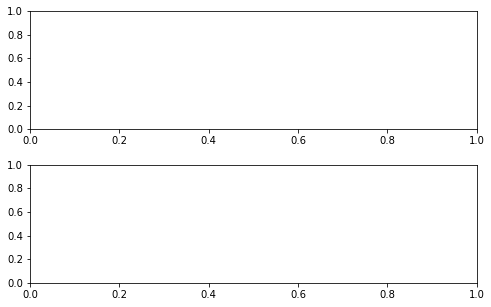

In [179]:
# year(s) and month(s) to process:
# years from 2012 to 2019 and months 6-10 are typically available
years = range(2012,2020)

for year in years:
    # initialize output array - one per year
    print(f'initializeing xctd_thisyear for {year}')
    xctd_thisyear = xr.Dataset(coords={'z':zgrid, 't':time})
    # this year's data directory
    thisdir = f'{sizrsdir}SIZRS_{year}_AXCTDs/'
    print(thisdir)
    # months in this year
    monthdirs = sorted(glob.glob(thisdir + '*AXCTDs_*'))
    mcnt = 0
    for monthdir in monthdirs:
        mcnt+=1
        file_list = sorted(glob.glob(monthdir +  '*/AXCTD*.txt'))
        for filename in file_list:
            # load, skip the header, and close
            # print(filename)
            f = open(filename,'r')    
            header = f.readlines()[0:13] 
            f.close()

            # look for header line with lat/lon/date info
            for r in range(np.size(header)):
                i = header[r].find("North")
                if i>0:
                    # TO DO:  make more generic with regexp or similar
                    hsplit = header[r].split(" ")
                    if hsplit[1] == 'degrees': # some files are formatted like this
                        lat = float(hsplit[0])
                        lon = -1*(float(hsplit[5]))
                        time = np.datetime64(datetime.strptime(hsplit[-2],'%Y-%m-%d/%H%M'))
                    else: # some like this
                        lat = float(hsplit[0]) + float(hsplit[2])/60
                        lon = -1*(float(hsplit[6]) + float(hsplit[8])/60)
                        time = np.datetime64(datetime.strptime(hsplit[-2],'%Y-%m-%d/%H%M'))

            # load data into a pandas dataframe: 
            df = pd.read_csv(filename, sep='\s+', skiprows=15, names=["Depth", "Pres", "Temp", "Cond", "Salinity", "Sigma"])

            # interpolate each variable to zgrid and store in the xarray dataset:
            # add data to the new xarray dataset this_xctd
            this_xctd = xr.Dataset(coords={'z':zgrid, 't':time, 'x':lon, 'y':lat})
            for vbl in vbls:
                this_xctd[vbl] = xr.DataArray(data=np.interp(zgrid, df['Depth'], df[vbl]), dims=['z'])

           
            # if this is the first file in the year, initialize the xr dataset and add time
            if mcnt==1:
                xctd_thisyear = xr.Dataset(coords={'z':zgrid, 't':time})
                
             # concatenate files
            xctd_thisyear = xr.concat([xctd_thisyear, this_xctd], dim='t')
            
            # print(f'adding thisctd to xctd_thisyear for {year}')
    # at the end of each year, save to netcdf
    SIZRS = xctd_thisyear.copy() # copy to a new dataset
    SIZRS = SIZRS.sel(z=z_extract) # extract one depth (surface)
    SIZRS = SIZRS.sortby('t')  # make sure times are sorted
    # rename variables
    for vi in range(len(vbls)):
        SIZRS = SIZRS.rename_vars({vbls[vi]:vbls_save[vi]})

    filename_out = f'{savedir}SIZRS_{np.datetime_as_string(time, unit="Y")}.nc'
    print(f'saving {filename_out}')
    SIZRS.to_netcdf(filename_out)
    # print(f'deleting xctd_thisyear for {year}')
    del(xctd_thisyear)
    
# at the end of the last year, plot profiles
fig, axs = plt.subplots(2, 1, figsize=(8,5))
fig.subplots_adjust(hspace=0.3)

for vi in [0,1]:
    axx = axs[vi]
    axx.plot(np.transpose(xctd_thisyear[vbls[vi]].data), xctd_thisyear.z.data)
    axx.invert_yaxis()
    axx.set_title(f'{vbls[vi]} profiles')
    axx.set_ylabel('depth, m')

        


In [137]:
xctd_thismonth

<xarray.Dataset>
Dimensions:   (t: 8, z: 50)
Coordinates:
    x         (t) float64 -149.9 -149.9 -150.0 -150.1 ... -150.0 -150.0 -149.8
    y         (t) float64 71.91 71.91 72.92 74.0 75.0 75.98 77.0 77.69
  * z         (z) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 4.4 4.5 4.6 4.7 4.8 4.9
  * t         (t) datetime64[ns] 2018-10-09T21:00:00 ... 2018-10-10T00:06:00
Data variables:
    Salinity  (t, z) float64 25.4 25.4 25.4 25.4 ... 26.98 26.98 26.98 26.98
    Temp      (t, z) float64 -0.979 -0.979 -0.979 ... -1.455 -1.455 -1.455

./process/SIZRS_2019.nc
<xarray.DataArray 't' (t: 28)>
array(['2019-06-12T22:13:00.000000000', '2019-06-12T22:13:00.000000000',
       '2019-07-10T19:38:00.000000000', '2019-07-10T20:08:00.000000000',
       '2019-07-10T20:33:00.000000000', '2019-07-10T21:00:00.000000000',
       '2019-07-10T21:34:00.000000000', '2019-08-14T21:21:00.000000000',
       '2019-08-14T22:00:00.000000000', '2019-08-14T22:27:00.000000000',
       '2019-08-14T22:54:00.000000000', '2019-08-14T23:16:00.000000000',
       '2019-08-15T01:22:00.000000000', '2019-09-12T21:06:00.000000000',
       '2019-09-12T21:31:00.000000000', '2019-09-12T22:00:00.000000000',
       '2019-09-12T22:26:00.000000000', '2019-09-12T22:49:00.000000000',
       '2019-09-12T23:17:00.000000000', '2019-09-12T23:42:00.000000000',
       '2019-09-13T00:07:00.000000000', '2019-09-13T02:33:00.000000000',
       '2019-10-10T18:06:00.000000000', '2019-10-10T18:31:00.000000000',
       '2019-10-10T18:55:00.000000000', '2019-10-10T19:22:00.00000000

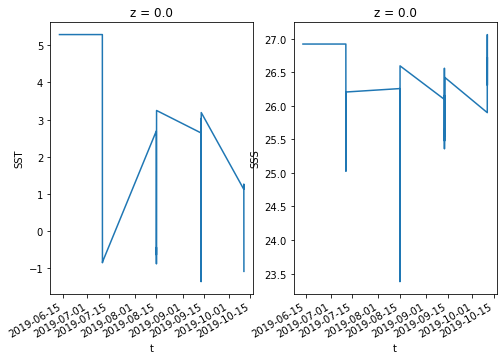

In [177]:
# check the files
year = 2019
filename = f'{savedir}SIZRS_{year}.nc'
print(filename)
ds = xr.open_dataset(filename)


fig, axs = plt.subplots(1, 2, figsize=(8,5))

for vi in [0,1]:
    axx = axs[vi]
    # axx.scatter(ds.x, ds.y, c=ds[vbls_save[vi]])
    ds[vbls_save[vi]].plot(ax=axx, x='t')
#     axx.plot(
        
#         np.transpose(xctd_thisyear[vbls[vi]].data), xctd_thisyear.z.data)
#     axx.invert_yaxis()
#     axx.set_title(f'{vbls[vi]} profiles')
#     axx.set_ylabel('depth, m')

print(ds.t)
ds.close()
